In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp
import h5py

import holodeck as holo
import holodeck.single_sources as ss
from holodeck.constants import YR, MSOL
from holodeck import utils, detstats


import hasasia.sensitivity as hsen
import hasasia.sim as hsim

## Goal:
Pass in an hdf5 file from a library of param spaces and return the average detection probability.

## Steps:
1) Read in file: fobs, hc_ss, hc_bg
2) Produce make a PTA set-up calibrated to 50% hc_bg DP?
3) Given pulsar setup and hdf file, calculate average ss DP and average bg DP
    * Calculate bg DP for each of R strain realizations
    * Build S sky realizations
    * Calculate ss DP for each of S sky realizations for each of R strain realizations.


# Step 1. Read in hdf file

In [6]:
ssfile = h5py.File('/Users/emigardiner/GWs/holodeck/output/2023-05-09-mbp-ss13_n10_r10_f20_l5_p1_s10/ss_lib.hdf5', 'r')
print(list(ssfile.keys()))
# print(ssfile['pta_dur'][0])
fobs = ssfile['fobs'][:]
dfobs = ssfile['dfobs'][:]
dur = ssfile['pta_dur'][0]
cad = ssfile['pta_cad'][0]
hc_ss_all = ssfile['hc_ss'][...]
hc_bg_all = ssfile['hc_bg'][...]
nsamp = len(hc_bg_all)
nreals = len(hc_bg_all[0,0])
ssfile.close()

['bgpar', 'dfobs', 'fobs', 'hc_bg', 'hc_ss', 'pta_cad', 'pta_dur', 'sample_params', 'sspar']


In [8]:
print('samples (N):', nsamp, '\nreals (R):', nreals, '\nN,F,R,L:', hc_ss_all.shape)

samples (N): 10 
reals (R): 10 
N,F,R,L: (10, 20, 10, 5)


## single realization example

# Step 2. build PTA
Here I am doing this randomly, but really it should be calibrated to hc_bg. Unsure how to do this, if it should be calibrated independently for each strain realization (R), a single pta should be used for all calculations, or positions etc. should be randomized for each iteration. We could even have pta realizations, on top of the strain realizations and the (single source) sky realizations, but that sounds like a nightmare.

The pulsars object is used to store thetas, phis, and sigmas of the pta. With this, use the detect_bg_pta(pulsars, spectra,...) and detect_ss_pta(pulsars,...) functions in detstats. Alternatively, you can just pass in the phis, thetas, and sigmas array to the detect_bg() and detect_ss() functions.

In [25]:
npsrs = 40
phis = np.random.uniform(0, 2*np.pi, size = npsrs)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
sigmas = np.ones_like(phis)*1e-6
# build sim_pta
pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)


# Step 3. Calculate detstats
Given pulsar setup, and hdf file, calculate average ss DP

Parameters and functions needed:
* def detect_bg_pta(
    - pulsars, 
    - fobs, 
    - cad, 
    - hc_bg, 
    - alpha_0=0.001, 
    - ret_all = False):
* def detect_ss_pta(
    - pulsars, 
    - cad, 
    - dur, 
    - fobs,
    - dfobs, 
    - hc_ss, 
    - hc_bg
    - theta_ss
    - phi_ss=None, 
    - Phi0_ss=None, 
    - iota_ss=None, 
    - psi_ss=None):

## 3.1 BG DP

In [5]:
dp = detstats.detect_bg(thetas, phis, sigmas, fobs, cad, hc_bg_all[0])
print(dp)

Sh_bg: (20, 10)
noise: (40,)
sigma_0B: (10,)
sigma_1B: (10,)
mu_1B: (10,)
dp_bg (10,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


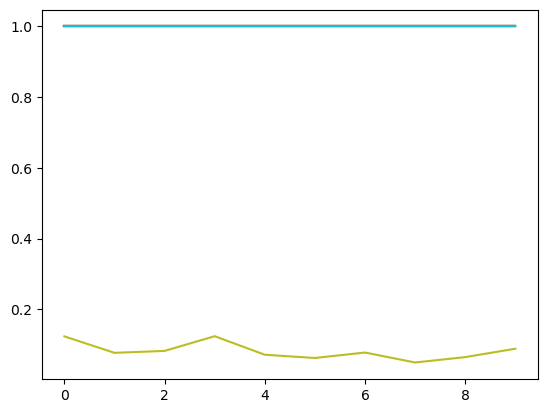

In [15]:
dp_bg_all = np.zeros((nsamp, nreals)) # (N,R)
for nn in range(nsamp):
    dp_bg_all[nn,:] = detstats.detect_bg_pta(pulsars, fobs, cad, hc_bg_all[nn])
for nn in range(nsamp):
    plt.plot(np.arange(nreals), dp_bg_all[nn,:])

# Appendix: Regular Old Detection Statistic Calculation

### A.1 build sam and calculate gws

In [125]:
dur = 15.0*YR
cad = .2*YR
fobs = utils.nyquist_freqs(dur,cad)
fobs_edges = utils.nyquist_freqs_edges(dur,cad)
dfobs = np.diff(fobs_edges)
sam = holo.sam.Semi_Analytic_Model() 
# sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
hc_ss_one, hc_bg_one = sam.ss_gwb(fobs_edges, realize=20, loudest=100)

SS 1: 
Current memory usage: max=2.87 GB, RSS=1.29 GB, VMS=392.37 GB
20:39:45 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
20:39:45 INFO : Stalled SAM bins based on GMT: 2.58e+05/6.53e+05 = 3.96e-01 [sam.py:static_binary_density]
20:39:45 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
20:39:45 INFO : 	dens bef: (0.00e+00, 0.00e+00, 3.29e-61, 8.58e-04, 1.48e-02, 2.79e-02, 4.47e-02) [sam.py:static_binary_density]
20:40:00 INFO : Scatter added after 15.222039 sec [sam.py:static_binary_density]
20:40:00 INFO : 	dens aft: (6.72e-29, 2.61e-15, 3.78e-09, 1.03e-03, 1.50e-02, 2.80e-02, 4.26e-02) [sam.py:static_binary_density]
20:40:00 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.7939e-03 [sam.py:static_binary_density]
20:40:00 INFO : zeroing out 2.58e+05/6.53e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
20:40:01 INFO : fraction of coalesced binaries: 3.28e+06/2.41e+07 = 1.36e-01 [sam.py:dynamic_binary_nu

### A.2 build pta

In [120]:
npsrs = 40
phis = np.random.uniform(0, 2*np.pi, size = npsrs)
thetas = np.random.uniform(np.pi/2, np.pi/2, size = npsrs)
sigmas = np.ones_like(phis)*5.2e-6
# build sim_pta
pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                    phi=phis, theta=thetas)


### A.3 calculate bg DP

Sh_bg: (37, 20)
noise: (40,)
sigma_0B: (20,)
sigma_1B: (20,)
mu_1B: (20,)
dp_bg (20,)
[0.17306829 0.1701515  0.15843439 0.16487215 0.15830232 0.15956365
 0.17291881 0.16422539 0.16668266 0.17278136 0.1739733  0.17541052
 0.17130874 0.16686991 0.17016079 0.16675742 0.17544485 0.15105843
 0.17345266 0.1729733 ]
[0.17306829 0.1701515  0.15843439 0.16487215 0.15830232 0.15956365
 0.17291881 0.16422539 0.16668266 0.17278136 0.1739733  0.17541052
 0.17130874 0.16686991 0.17016079 0.16675742 0.17544485 0.15105843
 0.17345266 0.1729733 ]


Text(0.5, 1.0, 'default SAM, F,R,L =(37, 20, 100)\nsigmas=5.20e-06')

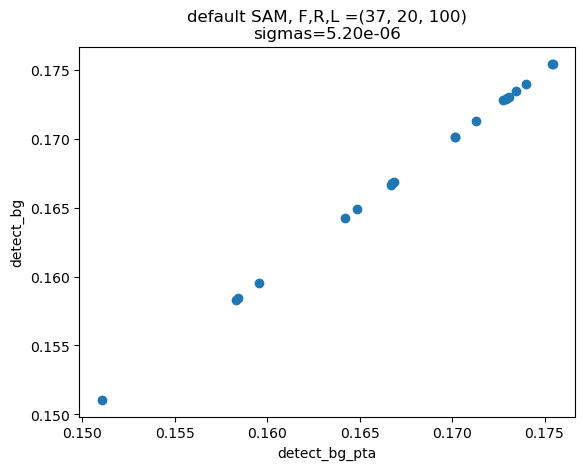

In [126]:
dp_bg1 = detstats.detect_bg_pta(pulsars, fobs, cad, hc_bg_one)
dp_bg2 = detstats.detect_bg(thetas, phis, sigmas, fobs, cad, hc_bg_one)
plt.scatter(dp_bg1, dp_bg2)
print(dp_bg1)
print(dp_bg2)
plt.xlabel('detect_bg_pta')
plt.ylabel('detect_bg')
plt.title(('default SAM, F,R,L ='+ str(hc_ss_one.shape)+'\nsigmas=%.2e' %sigmas[0]))


### A.4 build ss sky realizations

In [64]:
print(hc_ss_one.shape)

(37, 20, 1)


In [128]:
S = 15
F = len(hc_ss_one)
L = len(hc_ss_one[0,0])
theta_ss = np.random.uniform(0, np.pi, size=F*S*L).reshape(F,S,L)
phi_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
Phi0_ss = np.random.uniform(0,2*np.pi, size=theta_ss.size).reshape(theta_ss.shape)
iota_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)
psi_ss = np.random.uniform(0, np.pi, size = theta_ss.size).reshape(theta_ss.shape)

### A.5 calculate ss DP

In [ ]:
dp_ss1 = detstats.detect